##### Application


In [4]:
# load the model
import joblib
model = joblib.load('../rf_model.pkl')
imputer = joblib.load('../imputer.pkl')
model_features = joblib.load('../model_features.pkl')

In [13]:
import pandas as pd
clean_df = pd.read_csv('../df_with_sentiment.csv')

In [14]:
#Test Example : <Dragon Quest Builders 2>  is released in 2018 
#and assume <Dragon Quest Builders 3> in 2025



df_prev = clean_df[clean_df['title'].str.contains('Dragon Quest Builders 2', case=False)]


In [15]:
df_prev.head()

,Unnamed: 0,title,platform,releaseDate,rating,genres,quote,score,total_sales,original_price,release_year,release_quarter,release_month,processed_tokens,clean_text_stemmed,clean_text_lemmatized,sentiment,predicted_sentiment,sentiment_score
19,1333,Dragon Quest Builders 2,Nintendo Switch,2019-07-12,E10+,Sandbox,"Despite certain performance problems, Dragon Q...",87.0,0.14,49.99,2019,3,7,"{'original_tokens': ['despite', 'certain', 'pe...",despit certain perform problem dragon quest bu...,despite certain performance problem dragon que...,positive,positive,1
39,1240,Dragon Quest Builders 2,Nintendo Switch,2019-07-12,E10+,Sandbox,As someone who had enjoyed the first Dragon Qu...,9.0,0.14,49.99,2019,3,7,"{'original_tokens': ['someone', 'enjoyed', 'fi...",someon enjoy first dragon quest builder despit...,someone enjoyed first dragon quest builder des...,positive,positive,1
563,1263,Dragon Quest Builders 2,Nintendo Switch,2019-07-12,E10+,Sandbox,I would like to say that I really enjoyed this...,4.0,0.14,49.99,2019,3,7,"{'original_tokens': ['would', 'like', 'say', '...",would like say realli enjoy game first game be...,would like say really enjoyed game first game ...,positive,positive,1
569,1219,Dragon Quest Builders 2,Nintendo Switch,2019-07-12,E10+,Sandbox,This is a criminally underplayed game. I didn'...,10.0,0.14,49.99,2019,3,7,"{'original_tokens': ['criminally', 'underplaye...",crimin underplay game play first one enjoy dem...,criminally underplayed game play first one enj...,positive,positive,1
646,1323,Dragon Quest Builders 2,Nintendo Switch,2019-07-12,E10+,Sandbox,It was hard for me to imagine a way to expand ...,90.0,0.14,49.99,2019,3,7,"{'original_tokens': ['hard', 'imagine', 'way',...",hard imagin way expand game alreadi god dragon...,hard imagine way expand game already god drago...,positive,positive,1


In [17]:


# Step 2: To get the privous version info as new input
prev_sentiment = df_prev['sentiment_score'].mean()
prev_quote_length = df_prev['quote'].apply(lambda x: len(str(x))).mean()
#prev_sales = df_prev['total_sales'].mean()
prev_price = df_prev['original_price'].mean()

# Step 3: Assume/Define other inputs (score, release_year etc...)
X_new = pd.DataFrame([{
    'score': 88,
    'original_price':prev_price,
    'release_year': 2025,
    'release_month': 11,
    'quote_length': prev_quote_length,
    'sentiment_score': prev_sentiment,
    'platform_Nintendo Switch': 1,
    'platform_PC': 0,
    'platform_PlayStation 4': 0,
    'platform_Xbox One': 0,
    'rating_E': 0,
    'rating_E10+': 0,
    'rating_T': 0,
    'rating_M': 0,
    'rating_Unknown': 0,
    'genres_Racing': 0,
    'genres_Adventure': 0,
    'genres_JRPG': 0,
    'genres_Platformer': 0,
    'genres_Unknown': 0,
    'genres_Sandbox': 1,
}])
# 自動補上缺失欄位
for col in model_features:
    if col not in X_new.columns:
        X_new[col] = 0


# 丟掉多餘欄位，只保留模型認識的特徵
X_new = X_new[model_features]

# Step 4: 預測
X_new_imputed = pd.DataFrame(imputer.transform(X_new), columns=X_new.columns)
predicted_sales = model.predict(X_new_imputed)[0]
print(f" predicted sales : {predicted_sales:.2f} million ")



 predicted sales : 0.06 million 


In [36]:
import numpy as np
# 過濾出相同平台與類型的遊戲（可再加入 score 門檻）
similar_games = clean_df[
    (clean_df['platform'] == 'Nintendo Switch') &
    (clean_df['genres'].isin(['Sandbox']))
]

similar_games.head(10)

min_price = similar_games['original_price'].min()
max_price = similar_games['original_price'].max()
print(f"The price range of similar-genre games is :${min_price} ~ ${max_price}")

#Create a price range from min_price to max_price, increasing by $1 each time.
#This will be used to simulate and evaluate the impact of different price points on sales and revenue.
price_range = np.arange(min_price, max_price, 1 )  


revenues = []
predicted_sales_list = []

for p in price_range:
    features = {
        'score': 40,
        'original_price':p,  # to interate price_range 
        'release_year': 2025,
        'release_month': 11,
        'quote_length': prev_quote_length,
        'sentiment_score': prev_sentiment,
        'platform_Nintendo Switch': 1,
        'platform_PC': 0,
        'platform_PlayStation 4': 0,
        'platform_Xbox One': 0,
        'rating_E': 0,
        'rating_E10+': 0,
        'rating_T': 0,
        'rating_M': 0,
        'rating_Unknown': 0,
        'genres_Racing': 0,
        'genres_Adventure': 0,
        'genres_JRPG': 0,
        'genres_Platformer': 0,
        'genres_Unknown': 0,
        'genres_Sandbox': 1,
    }

    X_test = pd.DataFrame([features])
    for col in model_features:
        if col not in X_test.columns:
            X_test[col] = 0
    X_test = X_test[model_features]
    X_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    predicted_sales = model.predict(X_imputed)[0]
    revenue = p * predicted_sales
    predicted_sales_list.append(predicted_sales)
    revenues.append(revenue)


best_idx = np.argmax(revenues)
best_price = price_range[best_idx]
best_revenue = revenues[best_idx]
best_sales = predicted_sales_list[best_idx]



print(f"Best price: ${best_price}, Predicted sales: {best_sales:.2f} million units. Maximum projected revenue: ${best_revenue:.2f} million USD.")


The price range of similar-genre games is :$14.99 ~ $49.99
Best price: $36.99, Predicted sales: 0.16 million units. Maximum projected revenue: $6.05 million USD.


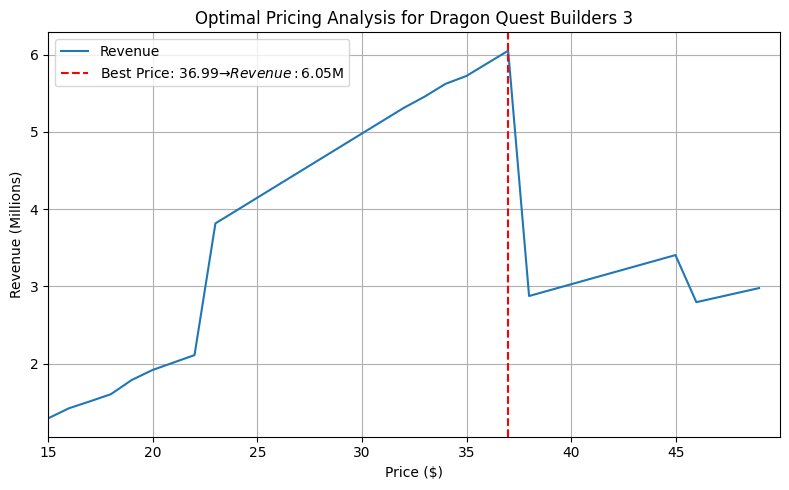

In [37]:
# Create the plot

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(price_range, revenues, label='Revenue')
plt.xlabel('Price ($)')
plt.ylabel('Revenue (Millions)')
plt.title('Optimal Pricing Analysis for Dragon Quest Builders 3')
plt.grid(True)
plt.xlim(min_price, max_price)
plt.axvline(
    x=best_price,
    color='r',
    linestyle='--',
    label=f'Best Price: ${best_price:.2f} → Revenue: ${best_revenue:.2f}M'
)
plt.legend()
plt.tight_layout()
plt.show()